In [14]:
#import packages
import pandas as pd
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.layers import LSTM
from keras.layers import Dense

In [3]:
#read train data
data = pd.read_csv(r"D:\Triloki\kaggle\train.csv")
data.shape

(20800, 5)

In [4]:
#print top 3 rows
data.head(3)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1


In [6]:
#information about train data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [8]:
#droping na data
data = data.dropna()
data.shape

(18285, 5)

In [12]:
#features
X = data.drop("label",axis=1)
X.shape

(18285, 4)

In [13]:
#label/target
y = data["label"]
y.shape

(18285,)

In [15]:
import re #for regular espression
from nltk.corpus import stopwords #for stopword remove
from nltk.stem.porter import PorterStemmer #for stemming

In [16]:
message = X.copy()
message.head(3)

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."


In [17]:
#reset index because we removed na rows
message.reset_index(inplace=True)
message.head(3)

,index,id,title,author,text
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."


In [18]:
#creating corpus
ps = PorterStemmer()
corpus = []
for i in range(0, len(message)):
    review = re.sub('[^a-zA-Z]', ' ', message['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [20]:
corpus[0:5]

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri']

In [21]:
#onehot Representation
voc_size = 5000
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [23]:
onehot_repr[0:5]

[[250, 1330, 3507, 1728, 396, 4089, 1709, 1604, 4645, 3741],
 [4701, 2871, 2760, 4110, 681, 2375, 4497],
 [3244, 271, 1287, 1835],
 [612, 287, 4585, 3236, 920, 3148],
 [41, 681, 1022, 1106, 4989, 3512, 681, 4242, 3373, 3952]]

In [28]:
#Embedding Representation
sent_len = 20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_len)
print(embedded_docs)

[[   0    0    0 ... 1604 4645 3741]
 [   0    0    0 ...  681 2375 4497]
 [   0    0    0 ...  271 1287 1835]
 ...
 [   0    0    0 ... 1468 4427 1562]
 [   0    0    0 ... 4586  469 2670]
 [   0    0    0 ... 3182 2751  257]]


In [29]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  250,
       1330, 3507, 1728,  396, 4089, 1709, 1604, 4645, 3741])

In [30]:
#creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_len))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)
X_final.shape,y_final.shape

((18285, 20), (18285,))

In [32]:
#split data into train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [40]:
#training/ fit the model
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Train on 12250 samples, validate on 6035 samples
Epoch 1/10
12250/12250 [==============================] - 8s 645us/step - loss: 0.0200 - accuracy: 0.9931 - val_loss: 0.4286 - val_accuracy: 0.9029
Epoch 2/10
12250/12250 [==============================] - 8s 652us/step - loss: 0.0183 - accuracy: 0.9933 - val_loss: 0.4487 - val_accuracy: 0.9042
Epoch 3/10
12250/12250 [==============================] - 8s 650us/step - loss: 0.0134 - accuracy: 0.9957 - val_loss: 0.5544 - val_accuracy: 0.9036
Epoch 4/10
12250/12250 [==============================] - 8s 646us/step - loss: 0.0121 - accuracy: 0.9965 - val_loss: 0.5983 - val_accuracy: 0.9094
Epoch 5/10
12250/12250 [==============================] - 8s 652us/step - loss: 0.0135 - accuracy: 0.9956 - val_loss: 0.4755 - val_accuracy: 0.9039
Epoch 6/10
12250/12250 [==============================] - 8s 654us/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.5005 - val_accuracy: 0.9065
Epoch 7/10
12250/12250 [==============================] - 8s 64

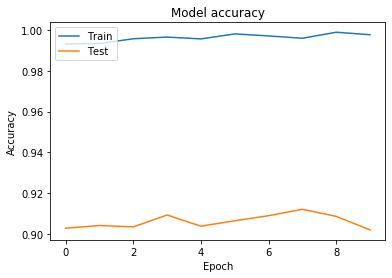

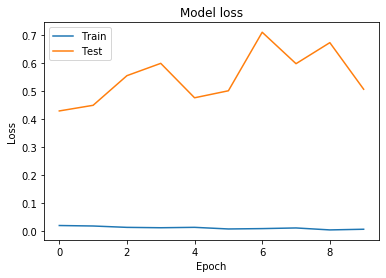

In [41]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [36]:
from keras.layers import Dropout
## Creating model with dropout
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_len))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [37]:
#training/ fit the model
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

C:\Users\ORMAE\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 12250 samples, validate on 6035 samples
Epoch 1/10
12250/12250 [==============================] - 9s 752us/step - loss: 0.3413 - accuracy: 0.8343 - val_loss: 0.1984 - val_accuracy: 0.9167
Epoch 2/10
12250/12250 [==============================] - 8s 672us/step - loss: 0.1472 - accuracy: 0.9416 - val_loss: 0.1933 - val_accuracy: 0.9201
Epoch 3/10
12250/12250 [==============================] - 8s 661us/step - loss: 0.1115 - accuracy: 0.9592 - val_loss: 0.2056 - val_accuracy: 0.9097
Epoch 4/10
12250/12250 [==============================] - 8s 663us/step - loss: 0.0860 - accuracy: 0.9692 - val_loss: 0.2611 - val_accuracy: 0.9150
Epoch 5/10
12250/12250 [==============================] - 8s 653us/step - loss: 0.0705 - accuracy: 0.9742 - val_loss: 0.2881 - val_accuracy: 0.9142
Epoch 6/10
12250/12250 [==============================] - 8s 658us/step - loss: 0.0497 - accuracy: 0.9823 - val_loss: 0.3075 - val_accuracy: 0.9130
Epoch 7/10
12250/12250 [==============================] - 8s 64

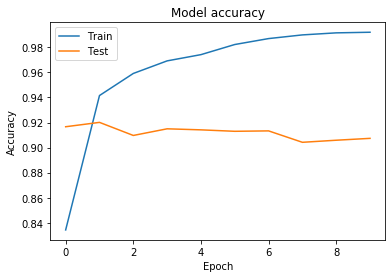

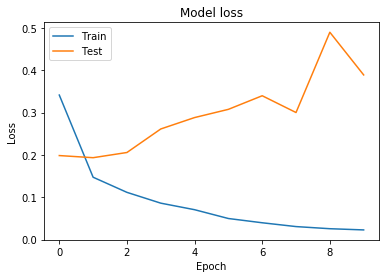

In [39]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()